<div class="admonition abstract highlight">
    <p class="admonition-title">In short</p>
    <p>This tutorial shows how we can use the curation API of the Polaris library to check and improve the quality of a dataset.</p>
</div>

<div class="admonition warning highlight">
    <p class="admonition-title">On the nuances of curation</p>
    <p>How to best curate a dataset is highly situation-dependent. The Polaris library includes some useful tools, but blindly applying them won't necessarily lead to good datasets. To learn more, visit <a href="https://www.polarishub.io">the Polaris Hub</a> for extensive resources and documentation on dataset curation and more.</p>
</div>

Data curation is concerned with analyzing and processing an existing dataset to maximize its quality. Within drug discovery, this can imply many things, such as filtering out outliers or flagging activity-cliffs. High-quality, well-curated datasets are the foundation upon which we can build realistic, impactful benchmarks for drug discovery. This notebook demonstrates how to curate your dataset with the Polaris data curation API for small molecules.

In [1]:
# Note: Cell is tagged to not show up in the mkdocs build
%load_ext autoreload
%autoreload 2

In [2]:
# Note: Cell is tagged to not show up in the mkdocs build
import warnings

warnings.filterwarnings("ignore")

In [3]:
import datamol as dm

from polaris import curation
from polaris.curation.viz_utils import (
    visualize_distribution,
    verify_stereoisomers,
    check_undefined_stereocenters,
)
from polaris.dataset import Dataset, ColumnAnnotation

### Curating the dataset

Let's start by loading our dataset from Datamol. 

<div class="admonition note highlight">
    <p class="admonition-title">The solubility dataset</p>
    <p>For the sake of simplicity, we will use the <a href="https://docs.datamol.io/stable/api/datamol.data.html#datamol.data.solubility">solubility dataset from Datamol</a>. It is worth noting that this dataset is only meant to be used as a toy dataset for pedagogic and testing purposes. It is <b>not a dataset for benchmarking, analysis or model training</b>. Curation can only take us so far. For impactful benchmarks, we rely on high-quality data sources to begin with.</p>

</p>
</div>


In [4]:
# Load your data set
# See more details of the dataset at https://docs.datamol.io/stable/api/datamol.data.html
dataset = dm.data.solubility()
dataset.head(5)

,mol,ID,NAME,SOL,SOL_classification,smiles,split
0,<rdkit.Chem.rdchem.Mol object at 0x2875a8900>,1,n-pentane,-3.18,(A) low,CCCCC,train
1,<rdkit.Chem.rdchem.Mol object at 0x2875a87b0>,2,cyclopentane,-2.64,(B) medium,C1CCCC1,train
2,<rdkit.Chem.rdchem.Mol object at 0x2875a8970>,3,n-hexane,-3.84,(A) low,CCCCCC,train
3,<rdkit.Chem.rdchem.Mol object at 0x2875a89e0>,4,2-methylpentane,-3.74,(A) low,CCCC(C)C,train
4,<rdkit.Chem.rdchem.Mol object at 0x2875a8a50>,6,"2,2-dimethylbutane",-3.55,(A) low,CCC(C)(C)C,train


To curate the data, we can use the `MolecularCurator` class. This requires us to specify some meta-data.

In [5]:
# Define the relevant columns
data_cols = ["SOL"]
mol_col = "mol"

# Define thresholds for converting continous values to classification task.
# This is optional, but can be a useful design decision in cases where data is sparse.
# The `label_order` indicates the optimization objective.
# "ascending" means that the higher the value, the more soluble the molecule
class_thresholds = {"SOL": {"thresholds": [-3, -1], "label_order": "ascending"}}

In [6]:
# Curate the dataset
curator_with_stereo = curation.MolecularCurator(
    data=dataset,
    data_cols=data_cols,
    mol_col=mol_col,
    mask_stereo_undefined_mols=True,
    class_thresholds=class_thresholds,  # Optional
)
df_curated = curator_with_stereo()
df_curated.head()

2023-10-13 16:49:20.966 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 7 outliers for data column SOL using zscore. Please revise the data and consider remove the outliers. 


,mol,ID,NAME,SOL,SOL_classification,smiles,split,ORIGINAL_SOL,ORIGINAL_mol,molhash_id,molhash_id_no_stereo,num_undefined_stereo_center,num_defined_stereo_center,OUTLIER_SOL,CLASS_SOL,CLASS_SOL_stereo_cliff
0,<rdkit.Chem.rdchem.Mol object at 0x2875d9930>,961,2-Hydroxypyridine,1.02,(C) high,Oc1ccccn1,train,1.02,<rdkit.Chem.rdchem.Mol object at 0x2875d9930>,0037189aacb54391feedfa522cf16897d860fb27,1ff8b846a251a16f898b7928540dd95fee68efe5,NaN,NaN,False,2.0,NaN
1,<rdkit.Chem.rdchem.Mol object at 0x2875c80b0>,162,1-chlorohexane,-3.12,(A) low,CCCCCCCl,train,-3.12,<rdkit.Chem.rdchem.Mol object at 0x2875c80b0>,004b647421e339205471399dca846b29ac6e6d8b,74e89b896cc17a9a9151dd9decbb7db0e240fbf5,NaN,NaN,False,0.0,NaN
2,<rdkit.Chem.rdchem.Mol object at 0x2890100b0>,316,"2,4-dimethyl-1-pentanol",-1.60,(B) medium,CC(C)CC(C)CO,test,-1.60,<rdkit.Chem.rdchem.Mol object at 0x2890100b0>,00abfdd5616f4ddb42e45a4aa5ba863ad3aa906f,fe343e0c524140cd79337700dc1800e409796cfb,1.0,0.0,False,1.0,NaN
3,<rdkit.Chem.rdchem.Mol object at 0x2875d7140>,849,triazolam,-4.08,(A) low,Cc1nnc2n1-c1ccc(Cl)cc1C(c1ccccc1Cl)=NC2,train,-4.08,<rdkit.Chem.rdchem.Mol object at 0x2875d7140>,00f93106bb7155995171846abae302368662aabe,e5358bd8ed80cfa6e163d51c3c5a5b86f5c3e051,NaN,NaN,False,0.0,NaN
4,<rdkit.Chem.rdchem.Mol object at 0x2875caf80>,297,2-methyl-3-pentanol,-0.70,(C) high,CCC(O)C(C)C,train,-0.70,<rdkit.Chem.rdchem.Mol object at 0x2875caf80>,01080e527e5356bb1ab7040faada11dce1e6caf9,e018694cd3b728969f1a886d3a1e055fa8080ee1,1.0,0.0,False,2.0,NaN


### Analyze the curation results
We made an effort to implement good standards for the `MolecularCurator` class, but - as we said before - how to best curate a dataset is situation dependent. There is no magic bullet! 

Let's first inspect the reported outliers.

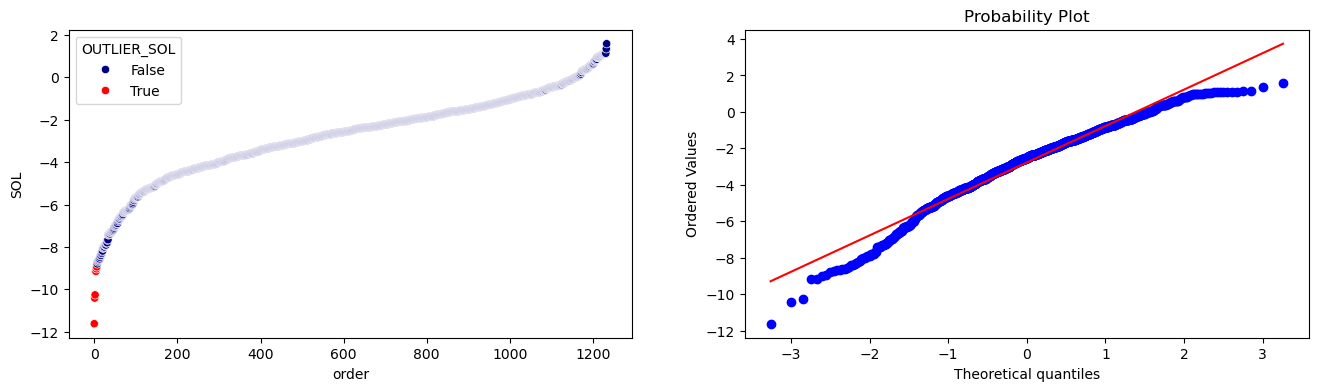

In [7]:
figs = visualize_distribution(["SOL"], df_curated)

And indeed: The flagged outliers do not seem to be true outliers as they are located on the terminals of the data distributions.

We can also further analyze the results with additional helper functions. Let's check for activity cliffs among the stereoisomers.

In [8]:
verify_stereoisomers(data_cols, df_curated)

2023-10-13 16:49:22.156 | INFO     | polaris.curation.viz_utils:verify_stereoisomers:56 - Verify the stereo ismomers for readout `SOL`
2023-10-13 16:49:22.157 | INFO     | polaris.curation.viz_utils:verify_stereoisomers:71 - No activity cliffs found in stereosimoers.


And visualize compounds with undefined stereocenters! 

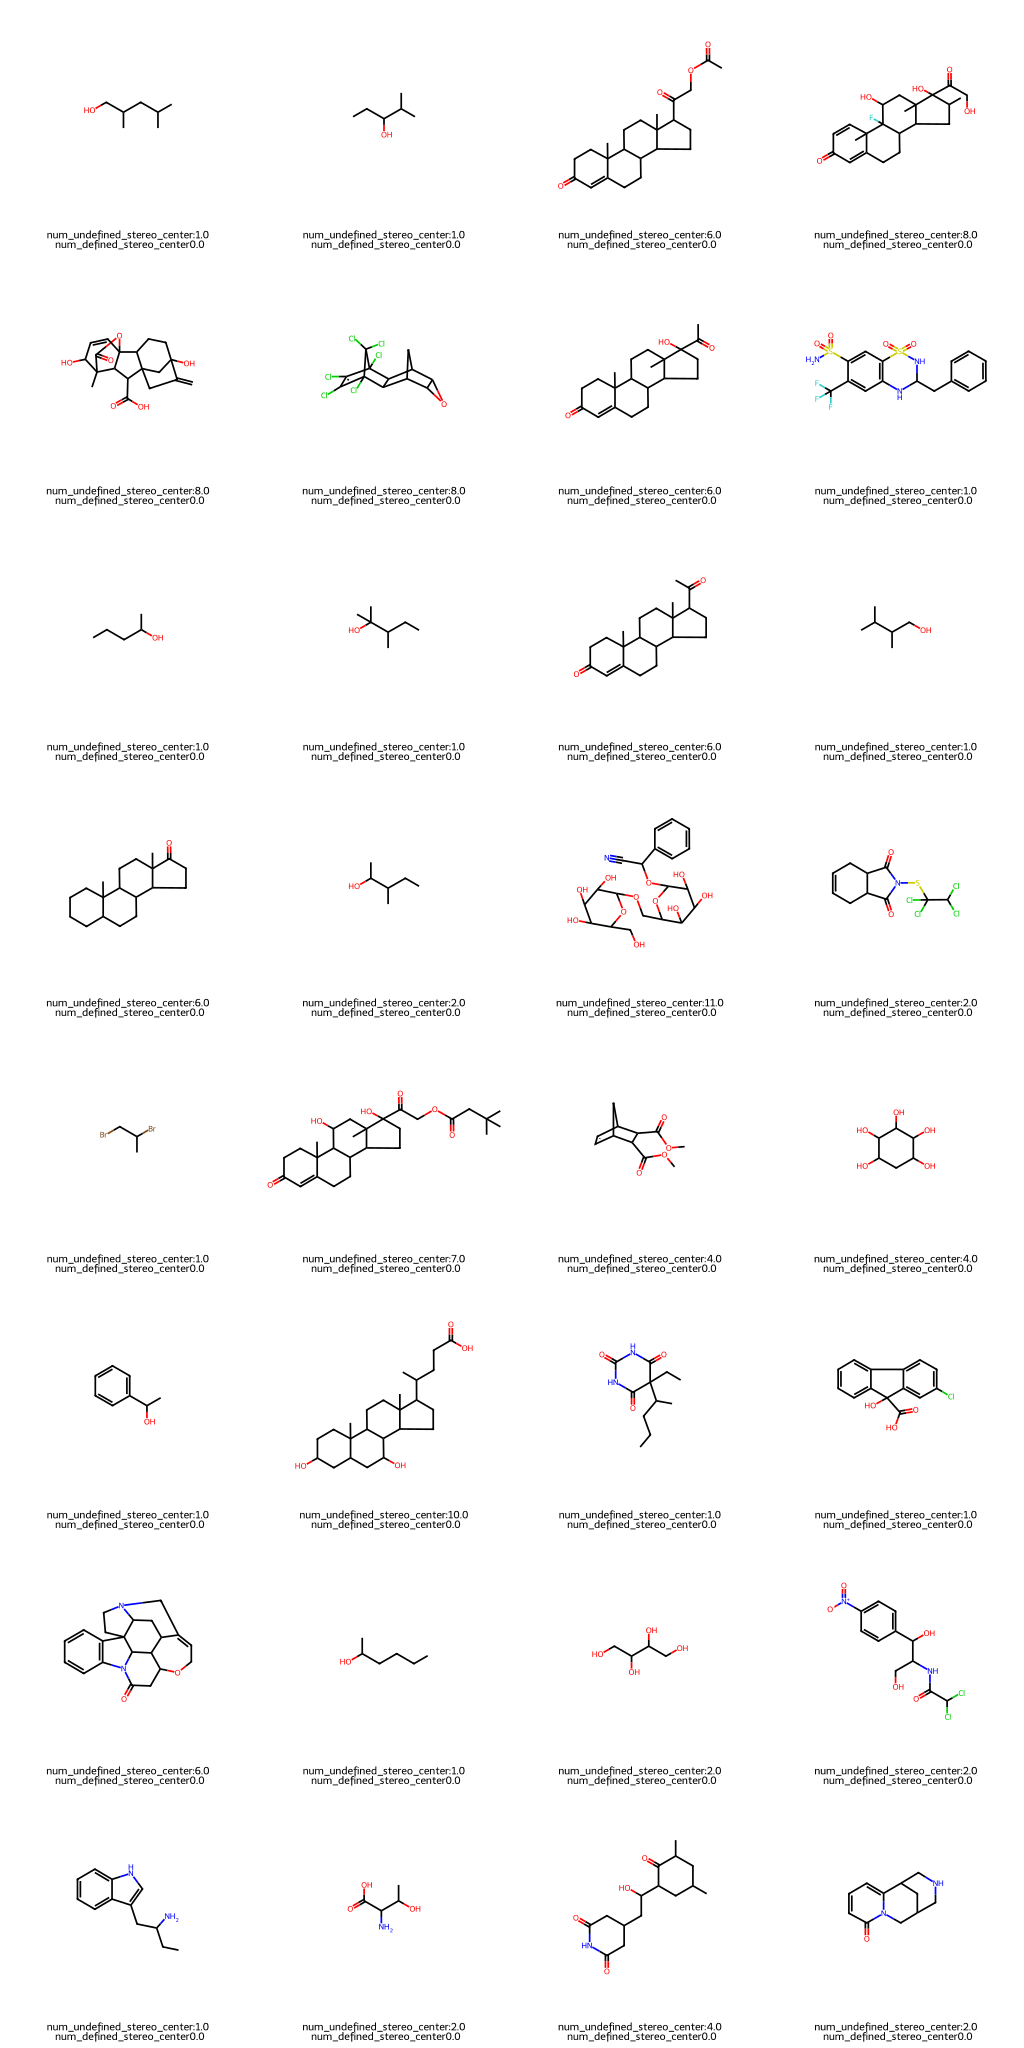

In [9]:
# show compounds with undefined stereocenters
check_undefined_stereocenters(df_curated)

Even though there are molecules with undefined stereocenters, in this dataset we find little evidence that shows the impact of stereochemisty on the solubility. However, there are publications that have demonstrated a significant difference in solubility between stereoisomers. This again shows that high-quality curation is situation-dependent and relies on domain expertise. 

---

This notebook only scratched the surface. There's many other things one could do to curate a dataset, such as: 
- Applying molecular prioritization and filtering rules, see e.g. [Medchem](https://github.com/datamol-io/medchem)
- Analyzing the distribution of the target and input space. 
- Training baseline models to evaluate the difficulty of the dataset.

The [Polaris Hub](https://www.polarishub.io) hosts additional documentation and resources to learn more about the intricacies of dataset curation.

In a next tutorial, we will see how we can add our datasets and benchmarks to the Polaris Hub.

The End. 

---